# Modelo Gradient Boosting

Al igual que la anterior fase de limpieza e inspección, este notebook también se encontrará organizado en diferentes bloques, los cuáles son mostrados a continuación:

* **BLOQUE 1**: Partición de los conjuntos de datos
* **BLOQUE 2**: Entrenamiento del modelo con todas las variables
* **BLOQUE 3**: Reducción del número de variables
* **BLOQUE 4**: Ajuste de hiperparámetros y modelo final

Asimismo, las primeras celdas corresponderán a la instalación y carga de las librerías necesarias para la ejecución del script.

### Librerías

In [1]:
#install.packages('xgboost')
#install.packages('caret')
#install.packages('e1071')
#install.packages('pROC')
#install.packages('Ckmeans.1d.dp')
#install.packages('ggplot2')
#install.packages('DiagrammeR')

library(xgboost)
library(caret)
library(e1071)
library(pROC)
library(Ckmeans.1d.dp)
library(ggplot2)
library(DiagrammeR)

Loading required package: ggplot2

Loading required package: lattice

Type 'citation("pROC")' for a citation.


Attaching package: ‘pROC’


The following objects are masked from ‘package:stats’:

    cov, smooth, var




## BLOQUE 1: Partición de los conjuntos de datos
En este primer bloque obtendremos los conjuntos necesarios para realizar el entrenamiento del modelo y poder observar y comparar el resultado del mismo.

In [2]:
# Lectura del fichero .csv obtenido
data <- read.csv('dataPrepared.csv', sep = ',', header = TRUE)
head(data)

,numero.granos,numero.piezas,longitud.objetivo,bombeo1,bombeo2,bombeo3,presion1,presion2,presion3,suciedad.molde,temperatura1,temperatura2,tiempo.solido,quimico1,quimico2,quimico3,quimico4,quimico5,defecto
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
1,0.1818182,0.2,0.2500000,0.6965610,0.07782671,0.31543624,0.6543779,0.8219178,0.5803842,0.00990099,0.5614035,0.5789474,0.1339973,0,0.4126074,0.2077922,0.1840909,0.55,0
2,1.0000000,1.0,0.0000000,0.6223871,0.02907488,0.00000000,0.7119816,0.5086758,0.1051567,0.73267327,0.3684211,0.3859649,0.1936860,0,0.6991404,0.2077922,0.8909091,0.55,0
3,0.0000000,0.0,0.8125000,0.8651382,0.07782671,0.41131352,0.7119816,0.8082191,0.6031345,0.60396040,0.6140351,0.5263158,0.5113145,0,0.4097421,0.2025974,0.2045455,0.45,1
4,0.0000000,0.0,1.0000000,0.8334457,0.07488984,0.43336529,0.6889401,0.9196348,0.1496461,0.70297030,0.8947368,0.9298246,0.1556628,0,0.4269341,0.1376623,0.1022727,0.55,0
5,0.1818182,0.4,0.1354167,0.7302765,0.14243760,0.20325983,0.7407834,0.7625571,0.3225480,0.79207921,0.5614035,0.5964912,1.0000000,0,0.6246418,0.3948052,0.6318182,0.60,0
6,0.2727273,0.6,0.0625000,1.0000000,0.14537441,0.07574305,1.0000000,0.7031964,0.9443883,0.66336634,0.4035088,0.3684211,0.2014265,0,0.6303725,0.4649351,0.9068182,0.25,0


El objetivo de esta fase es la de dividir el dataset anterior en tres conjuntos distintos teniendo en cuenta que el número de observaciones entre clases es muy distinto:

* Conjunto de entrenamiento -> balanceado 
* Conjunto de validación  -> balanceado
* Conjunto de test -> no balanceado

_Balanceado_ : mismo número de observaciones de cada clase

El proceso a seguir es el siguiente:
![particion_balanceo](img/particion_balanceo.png)

In [3]:
# Primera partición: Obtención del conjunto de test
n <- nrow(data)
set.seed(0)

train_index <- createDataPartition(data$defecto, p = .7, list = FALSE, times = 1)

entrenamiento <- data[train_index, ]  # Conjunto aún a dividir entre entrenamiento y validación
df_test <- data[-train_index, ]

print(dim(entrenamiento))
print(dim(df_test))

round(table(entrenamiento$defecto)/nrow(entrenamiento)*100, 2)
round(table(df_test$defecto)/nrow(df_test)*100, 2)

[1] 2704   19
[1] 1158   19



    0     1 
88.57 11.43 


    0     1 
89.29 10.71 

In [4]:
# Segunda partición: Obtención de los conjuntos de entrenamiento y validación
# IMPORTANTE!!: Balanceo de datasets. ¿Por qué?
cat('No defectos en el conjunto:', nrow(entrenamiento[entrenamiento$defecto == 0, ]), '\n')
cat('Defectos en conjunto:', nrow(entrenamiento[entrenamiento$defecto == 1, ]))

No defectos en el conjunto: 2395 
Defectos en conjunto: 309

In [5]:
# Balanceo 

# Balanceo de conjuntos.
set.seed(0)
entrenamiento_balanceado <- downSample(entrenamiento[, -20], factor(entrenamiento$defecto), list = FALSE)
entrenamiento_balanceado <- subset(entrenamiento_balanceado, select=-Class)

print(nrow(entrenamiento_balanceado))
table(entrenamiento_balanceado$defecto)

[1] 618



  0   1 
309 309 

In [6]:
# Segunda partición

set.seed(0)
train_index2 <- createDataPartition(entrenamiento_balanceado$defecto, p = .7, list = FALSE, times = 1)

df_train <- entrenamiento_balanceado[train_index2, ]
df_valid <- entrenamiento_balanceado[-train_index2, ]

In [7]:
# Tamaño final de los conjuntos.
cat('Tamaño del conjunto de entrenamiento:', nrow(df_train), '\n')
cat('Tamaño del conjunto de validación:', nrow(df_valid), '\n')
cat('Tamaño del conjunto de test:', nrow(df_test))

Tamaño del conjunto de entrenamiento: 434 
Tamaño del conjunto de validación: 184 
Tamaño del conjunto de test: 1158

In [8]:
# Separamos de los conjuntos la variable objeto de estudio
# Convertir en matrices, ya que la función para entrenar el modelo XGB no permite utilizar dataframes
X_train <- as.matrix(df_train[, which(names(df_train) != 'defecto')])
y_train <- df_train[, 'defecto']

X_valid <- as.matrix(df_valid[, which(names(df_valid) != 'defecto')])
y_valid <- df_valid[, 'defecto']

X_test <- as.matrix(df_test[, which(names(df_test) != 'defecto')])
y_test <- df_test[, 'defecto']

## BLOQUE 2: Entrenamiento del modelo con todas las variables

#### **¿Qué es _Boosting_?**

_Boosting_ es un meta-algoritmo de aprendizaje automático que reduce el sesgo y la varianza en un contexto de aprendizaje supervisado. Consiste en combinar los resultados de varios clasificadores débiles para obtener un clasificador robusto. Cuando se añaden estos clasificadores débiles, se hace de modo que éstos tengan diferente peso en función de la exactitud de sus predicciones. Tras añadir un clasificador débil, los datos cambian su estructura de pesos: los casos mal clasificados ganan peso y los que son clasificados correctamente pierden peso. 

**Gradient Boosting (GB)** o _Potenciación del gradiente_ consiste en plantear el problema como una optimización numérica en el que el objetivo es minimizar una función de coste añadiendo clasificadores débiles mediante el descenso del gradiente. Involucra tres elementos:

* La **función de coste** a optimizar: depende del tipo de problema a resolver.
* Un **clasificador débil** para hacer las predicciones: por lo general se usan árboles de decisión.
* Un **modelo que añade (ensambla) los clasificadores débiles** para minimizar la función de coste: se usa el descenso del gradiente para minimizar el coste al añadir árboles.

Para este problema utilizaremos la librería _XGBoost_, que es una implementación particular muy eficiente de Gradient Boosting.

Tutoriales de la librería en R:
* https://xgboost.readthedocs.io/en/latest/R-package/xgboostPresentation.html
* http://dmlc.github.io/rstats/2016/03/10/xgboost.html

Los hiperparámetros más importantes que intervienen en este algoritmo y que aquí utilizaremos se describen a continuación:

* Parámetros generales:
 * **nthread**: número de hilos paralelos usados en la ejecución.
 * **objetive**: objetivo del aprendizaje.
 * **eval_metric**: métrica de evaluación para el conjunto en cuestión.
 
 
* Parámetros propios del _Boosting_:
 * **eta (learning rate)**: determina el impacto de cada árbol en la salida final. Se parte de una estimación inicial que se va actualizando con la salida de cada árbol. Es el parámetro que controla la magnitud de las actualizaciones.
 * **nrounds**: número de árboles a utilizar.


* Parámetros propios de los árboles:
 * **max_depth**: profundidad máxima de un árbol.
 
Más información sobre los parámetros y la librería en general:
* https://xgboost.readthedocs.io/en/latest/parameter.html

In [9]:
head(X_train)

,numero.granos,numero.piezas,longitud.objetivo,bombeo1,bombeo2,bombeo3,presion1,presion2,presion3,suciedad.molde,temperatura1,temperatura2,tiempo.solido,quimico1,quimico2,quimico3,quimico4,quimico5
1,0.4545455,0.6,0.0625000,0.8651382,0.07400882,0.2924257,0.6370968,0.8648402,0.1557129,1.0000000,0.5438596,0.5438596,0.16277931,0,0.4240688,0.05974026,0.06363636,0.50
2,0.2727273,0.4,0.1354167,0.6999326,0.08076358,0.3279003,0.7523041,0.9086758,0.1557129,0.1386139,0.4385965,0.4561404,0.17997425,0,0.5931232,0.40000000,0.66363636,0.35
4,1.0000000,1.0,0.0000000,0.4571814,0.02907488,0.0000000,0.8041475,0.5251142,0.1253792,0.7326733,0.4736842,0.4912281,0.24512073,0,0.7106017,0.23376623,0.86818182,0.75
6,0.4545455,0.6,0.0625000,0.6999326,0.07488984,0.3279003,0.7523041,0.9589041,0.1102123,0.8118812,0.7894737,0.7543860,0.09758544,0,0.4126074,0.23896104,0.20909091,0.55
9,0.4545455,0.6,0.0625000,0.8213082,0.07782671,0.4995206,0.6486175,0.8566210,0.6476238,0.6039604,0.5614035,0.5438596,0.08937894,0,0.3954155,0.11948052,0.22500000,0.35
13,0.4545455,0.6,0.0625000,0.6965610,0.08370039,0.3154362,0.6543779,0.7945205,0.6107179,0.0000000,0.5614035,0.5614035,0.11764752,0,0.4212034,0.16883117,0.21818182,0.35


In [10]:
params <- list(nthread = 4,
               max_depth = 6,
               eta = 0.3,
               eval_metric = 'auc',
               objective = 'binary:logistic')

set.seed(0)
xgb_model <- xgboost(data = X_train, label = y_train, params = params, nrounds = 30, verbose = 1)

[1]	train-auc:0.934571 
[2]	train-auc:0.959884 
[3]	train-auc:0.969887 
[4]	train-auc:0.983690 
[5]	train-auc:0.988171 
[6]	train-auc:0.990189 
[7]	train-auc:0.993735 
[8]	train-auc:0.995923 
[9]	train-auc:0.997473 
[10]	train-auc:0.998067 
[11]	train-auc:0.998790 
[12]	train-auc:0.999151 
[13]	train-auc:0.999384 
[14]	train-auc:0.999512 
[15]	train-auc:0.999554 
[16]	train-auc:0.999735 
[17]	train-auc:0.999841 
[18]	train-auc:0.999841 
[19]	train-auc:0.999841 
[20]	train-auc:0.999894 
[21]	train-auc:0.999894 
[22]	train-auc:0.999915 
[23]	train-auc:0.999936 
[24]	train-auc:0.999958 
[25]	train-auc:0.999958 
[26]	train-auc:0.999958 
[27]	train-auc:0.999979 
[28]	train-auc:0.999979 
[29]	train-auc:1.000000 
[30]	train-auc:1.000000 


In [11]:
# Importancia de cada variable en el modelo
feature_importance <- xgb.importance(feature_names = xgb_model$feature_names, model = xgb_model)
feature_importance

Feature,Gain,Cover,Frequency
<chr>,<dbl>,<dbl>,<dbl>
longitud.objetivo,0.301916313,0.112005495,0.02466793
quimico4,0.108361386,0.104947270,0.10056926
temperatura1,0.107264960,0.109254448,0.07779886
tiempo.solido,0.087132920,0.136052409,0.16698292
presion2,0.079289561,0.086340069,0.09487666
bombeo2,0.053402147,0.041750260,0.04933586
suciedad.molde,0.051152066,0.063542231,0.06641366
presion3,0.047893703,0.078506885,0.08159393
quimico2,0.042436978,0.076624305,0.08728653


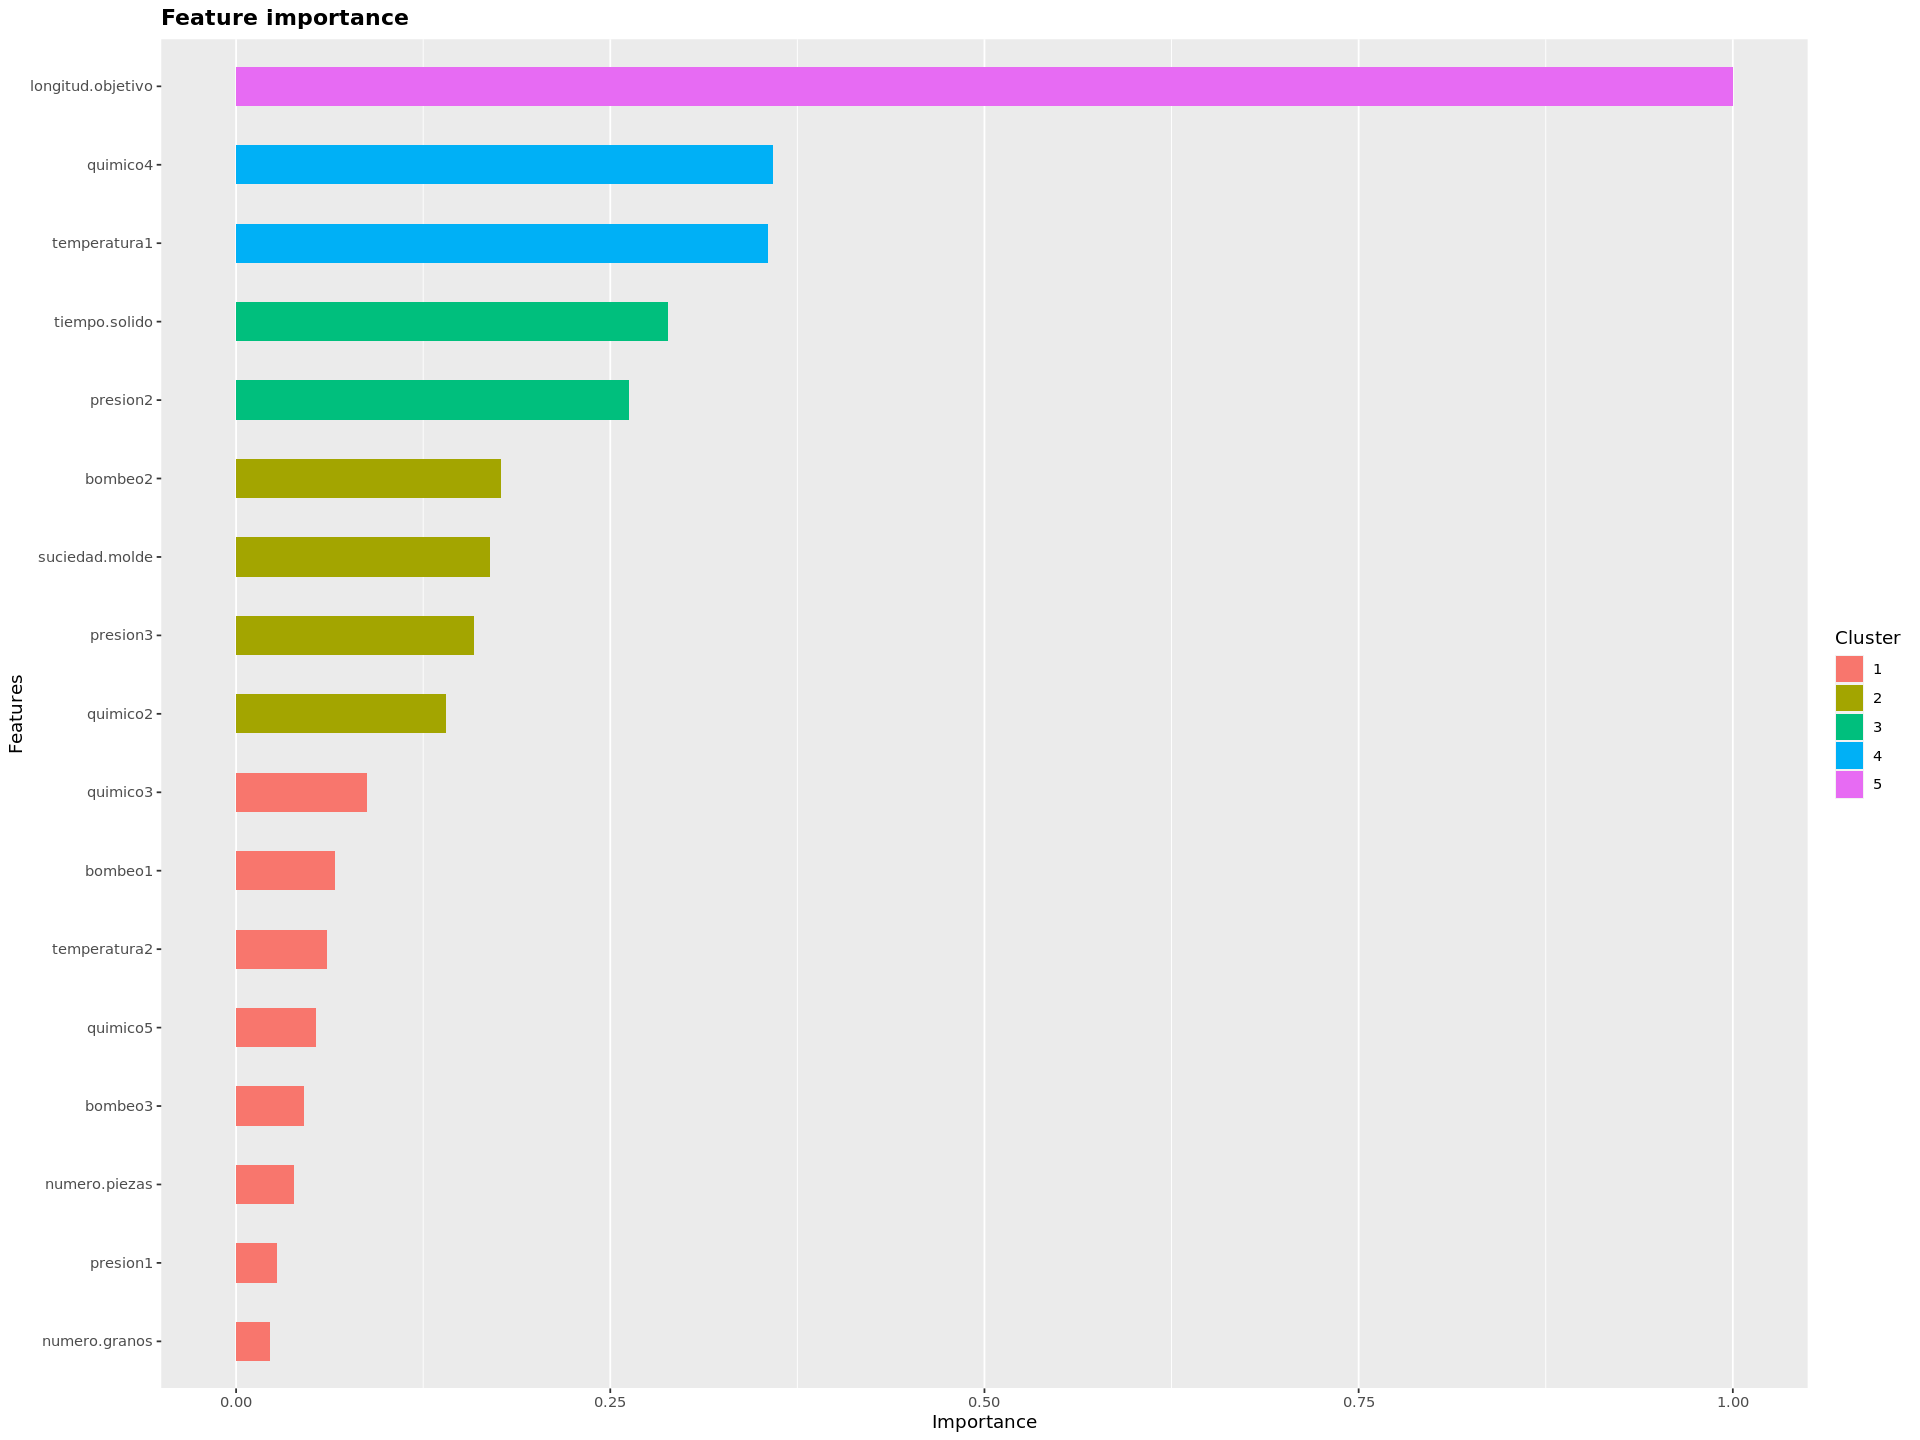

In [12]:
# Gráfico con la importancia
options(repr.plot.width = 16, repr.plot.height = 12)
xgb.ggplot.importance(importance_matrix = feature_importance, rel_to_first = TRUE)

Para poder ver como de bueno es nuestro modelo, podemos obtener las predicciones que realiza sobre los conjuntos de entrenamiento y validación, y realizar el cálculo de alguna métrica para observar su rendimiento. En este caso, observaremos el **área bajo la curva ROC** (más conocido simplemente como AUC).

In [13]:
# Ajuste/Rendimiento sobre datos de entrenamiento.
pred_train <- predict(xgb_model, X_train)

# Rendimiento sobre datos de validación
pred_valid <- predict(xgb_model, X_valid)

In [14]:
# Creamos un dataframe con la probabilidad de ser o no defectuosa la pieza
# y añadimos el cálculo de la predicción final

# Entrenamiento
predictions_train <- data.frame('probability' = pred_train, 
                                'prediction' = ifelse(pred_train > 0.5, 1, 0))

# Validación
predictions_valid <- data.frame('probability' = pred_valid, 
                                'prediction' = ifelse(pred_valid > 0.5, 1, 0))

In [15]:
# Cálculo de AUCs

# Entrenamiento
roc_train <- roc(y_train, predictions_train$prediction)
auc_train <- round(auc(roc_train), 4)

# Validación
roc_valid <- roc(y_valid, predictions_valid$prediction)
auc_valid <- round(auc(roc_valid), 4)

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



In [16]:
cat(paste('Área bajo la curva (AUC) en entrenamiento:', auc_train, '\n'))
cat(paste('Área bajo la curva (AUC) en validación:', auc_valid))

Área bajo la curva (AUC) en entrenamiento: 0.9977 
Área bajo la curva (AUC) en validación: 0.7554

## BLOQUE 3: Reducción del número de variables

En este bloque se estudiará si es posible reducir el número de variables a utilizar por el _Gradient Boosting_. Se trata de una fase muy importante, pues, como ya se ha visto al medir la importancia, **no todas las variables causan un impacto importante** en el modelo. Además, utilizar un menor número de variables es preferible ya que implica una **simplificación el modelo** y una mayor interpretabilidad.

Para encontrar el número más óptimo de variables entrenaremos diversos modelos de manera iterativa, incorporando de una en una las variables ordenadas por importancia en el modelo. Así, almacenaremos en cada iteración los AUC tanto del conjunto de entrenamiento como de validación, y observaremos con que número de variables obtenemos un rendimiento lo suficientemente bueno.

In [17]:
# Bucle for para obtener las AUCs del modelo según nº de variables
auc_features <- data.frame('num_variables' = numeric(), 'auc_train' = numeric(), 'auc_valid' = numeric())

for (i in 1:nrow(feature_importance)){
    cat('Entrenamiento del modelo con ', i, ' variables.\n')
    cat('================================================')
    
    # Reducción de conjuntos
    cols <- c(feature_importance[1:i, 'Feature'])$Feature
    X_train_red <- as.matrix(X_train[, cols])
    X_valid_red <- as.matrix(X_valid[, cols])
    
    # Ajuste del modelo y obtención de predicciones
    set.seed(0)
    model_red <- xgboost(data = X_train_red, label = y_train, params = params, nrounds = 30,
                         verbose = 0)
    
    pred_train <- predict(model_red, X_train_red)
    pred_train <- ifelse(pred_train > 0.5, 1, 0)
    
    pred_valid <- predict(model_red, X_valid_red)
    pred_valid <- ifelse(pred_valid > 0.5, 1, 0)
    
    # AUCs
    roc_train <- roc(y_train, pred_train)
    auc_train <- round(auc(roc_train), 4)
    
    roc_valid <- roc(y_valid, pred_valid)
    auc_valid <- round(auc(roc_valid), 4)
    
    # Añadimos la información al dataframe
    auc_features[i, 'num_variables'] <- i
    auc_features[i, 'auc_train'] <- auc_train
    auc_features[i, 'auc_valid'] <- auc_valid
}

Entrenamiento del modelo con  1  variables.

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



Entrenamiento del modelo con  2  variables.

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



Entrenamiento del modelo con  3  variables.

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



Entrenamiento del modelo con  4  variables.

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



Entrenamiento del modelo con  5  variables.

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



Entrenamiento del modelo con  6  variables.

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



Entrenamiento del modelo con  7  variables.

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



Entrenamiento del modelo con  8  variables.

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



Entrenamiento del modelo con  9  variables.

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



Entrenamiento del modelo con  10  variables.

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



Entrenamiento del modelo con  11  variables.

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



Entrenamiento del modelo con  12  variables.

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



Entrenamiento del modelo con  13  variables.

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



Entrenamiento del modelo con  14  variables.

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



Entrenamiento del modelo con  15  variables.

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



Entrenamiento del modelo con  16  variables.

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



Entrenamiento del modelo con  17  variables.

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



In [18]:
# Dataframe que contiene la información del proceso iterativo
auc_features

,num_variables,auc_train,auc_valid
,<dbl>,<dbl>,<dbl>
1,1,0.7880,0.7228
2,2,0.9009,0.7228
3,3,0.9493,0.7174
4,4,0.9816,0.7283
5,5,0.9931,0.7663
6,6,0.9954,0.7446
7,7,0.9931,0.7391
8,8,0.9954,0.7391
9,9,0.9954,0.7554


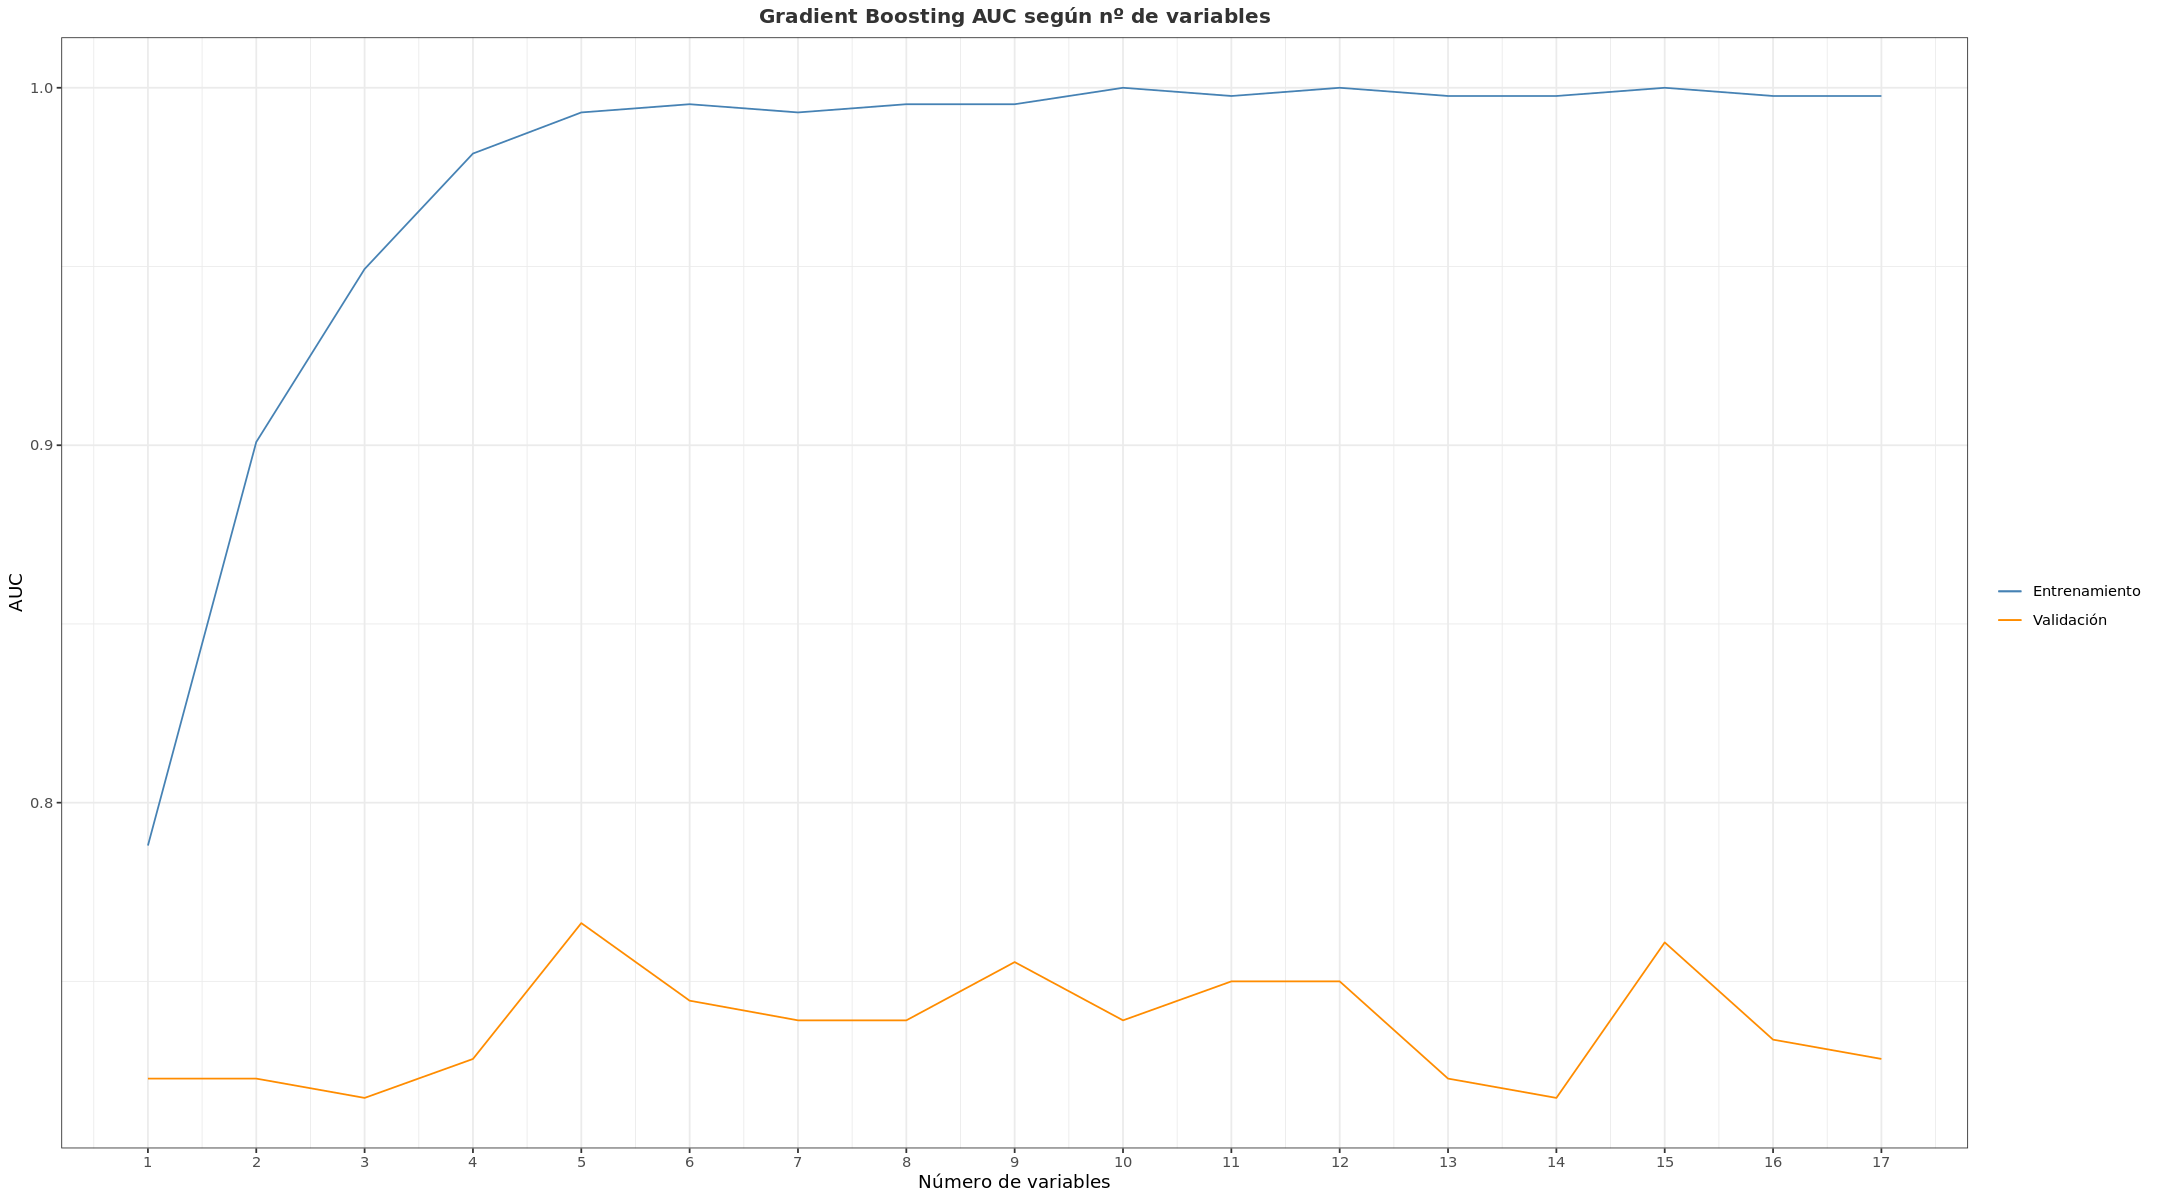

In [19]:
# Gráfico que permite visualizar el AUC de los conjuntos según el nº de variables utilizadas
options(repr.plot.width = 18, repr.plot.height = 10)

p <- ggplot(data = auc_features)
p <- p + geom_line(aes(x = num_variables, y = auc_train, colour = 'Entrenamiento'))
p <- p + geom_line(aes(x = num_variables, y = auc_valid, colour = 'Validación'))
p <- p + theme_bw()
p <- p + theme(plot.title = element_text(size = 12, hjust = 0.5, face = "bold", color= "grey20"))
p <- p + labs(title = 'Gradient Boosting AUC según nº de variables')
p <- p + scale_x_continuous('Número de variables', breaks = seq(1, nrow(auc_features), 1))
p <- p + scale_y_continuous('AUC')
p <- p + scale_color_manual('', breaks = c('Entrenamiento', 'Validación'), 
                             values = c('Entrenamiento' = 'steelblue', 'Validación' = 'darkorange'))
p

In [20]:
# Selección de las variables a utilizar
cols <- c(feature_importance[1:5, 'Feature'])$Feature

# Reducción de los conjuntos
X_train_red <- X_train[, cols]
X_valid_red <- X_valid[, cols]
X_test_red <- X_test[, cols]

In [21]:
# Nuevo modelo con la reducción de variables
set.seed(0)
xgb_model_red <- xgboost(data = X_train_red, label = y_train, params = params, nrounds = 30,
                         verbose = 0)

In [22]:
# Rendimiento del modelo en conjuntos de entrenamiento y validación (AUCs)

# Entrenamiento
pred_train <- predict(xgb_model_red, X_train_red)
pred_train <- ifelse(pred_train > 0.5, 1, 0)

roc_train <- roc(y_train, pred_train)
auc_train <- round(auc(roc_train), 4)

# Validación
pred_valid <- predict(xgb_model_red, X_valid_red)
pred_valid <- ifelse(pred_valid > 0.5, 1, 0)

roc_valid <- roc(y_valid, pred_valid)
auc_valid <- round(auc(roc_valid), 4)

# Resultados
cat('Área bajo la curva (AUC) en entrenamiento:', auc_train, '\n')
cat('Área bajo la curva (AUC) en validación:', auc_valid)

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



Área bajo la curva (AUC) en entrenamiento: 0.9931 
Área bajo la curva (AUC) en validación: 0.7663

## BLOQUE 4: Ajuste de hiperparámetros y modelo final

Una vez seleccionadas las variables a utilizar en nuestro modelo, faltaría realizar el correspondiente **ajuste de los hiperparámetros**. Estos valores deber ser establecidos antes del entrenamiento, y de su correcta elección dependerá el resultado que obtendremos.

Los hiperparámetros ideales dependen del perfil de los datos que estamos analizando, por lo que no es sencillo establecer un procedimiento estándar para su obtención. En este caso realizaremos un **ajuste manual** de los mismos, observando directamente el cambio en el rendimiento del modelo aplicado a los datos de validación.

In [23]:
# Cambio en los valores de los hiperparámetros
best_params <- list(objective = 'binary:logistic',
                    nthread = 4,
                    max_depth = 3,
                    eta = 0.2,
                    eval_metric = 'auc')

# Entrenamiento del modelo con los nuevos valores
set.seed(0)
best_xgb_model <- xgboost(data = X_train_red, label = y_train, params = best_params, nrounds = 50,
                          verbose = 0)

# Rendimiento del nuevo modelo en los conjuntos de entrenamiento y validación
# Entrenamiento
new_pred_train <- predict(best_xgb_model, X_train_red)
new_pred_train <- ifelse(new_pred_train > 0.5, 1, 0)

new_roc_train <- roc(y_train, new_pred_train)
new_auc_train <- round(auc(new_roc_train), 4)

# Validación
new_pred_valid <- predict(best_xgb_model, X_valid_red)
new_pred_valid <- ifelse(new_pred_valid > 0.5, 1, 0)

new_roc_valid <- roc(y_valid, new_pred_valid)
new_auc_valid <- round(auc(new_roc_valid), 4)

# Resultados
cat('Nuevo área bajo la curva (AUC) en entrenamiento:', new_auc_train, '\n')
cat('Nuevo área bajo la curva (AUC) en validación:', new_auc_valid)

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



Nuevo área bajo la curva (AUC) en entrenamiento: 0.9309 
Nuevo área bajo la curva (AUC) en validación: 0.7283

Obtenido ya nuestro mejor modelo, podemos observar su rendimiento sobre unos datos totalmente nuevos y más reales: el conjunto de test. Para ello, además de mostrar el AUC como veníamos haciendo a lo largo del análisis, observaremos también la **matriz de confusión**:

In [24]:
# Predicciones en conjunto de test
pred_test <- predict(best_xgb_model, X_test_red)
pred_test <- ifelse(pred_test > 0.5, 1, 0)

# Área bajo la curva
roc_test <- roc(y_test, pred_test)
auc_test <- round(auc(roc_test), 4)

cat('Área bajo la curva (AUC) en test:', auc_test)

Setting levels: control = 0, case = 1

Setting direction: controls < cases



Área bajo la curva (AUC) en test: 0.7665

In [25]:
# Matriz de confusión
cm_test <- round(prop.table(table(pred_test, y_test), 2)*100, 2)

cat('Matriz de confusión para datos de test:\n\n')
print(cm_test)

Matriz de confusión para datos de test:

         y_test
pred_test     0     1
        0 79.11 25.81
        1 20.89 74.19


In [26]:
# Otra manera de obtener la matriz de confusión, junto con otras métricas
cm_test2 <- confusionMatrix(as.factor(pred_test), as.factor(y_test), mode = 'everything',
                            positive = '1')
cm_test2

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 818  32
         1 216  92
                                          
               Accuracy : 0.7858          
                 95% CI : (0.7611, 0.8091)
    No Information Rate : 0.8929          
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0.3225          
                                          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.74194         
            Specificity : 0.79110         
         Pos Pred Value : 0.29870         
         Neg Pred Value : 0.96235         
              Precision : 0.29870         
                 Recall : 0.74194         
                     F1 : 0.42593         
             Prevalence : 0.10708         
         Detection Rate : 0.07945         
   Detection Prevalence : 0.26598         
      Balanced Accuracy : 0.76

También es posible si se desea observar los árboles que son construidos en el modelo y que establecen las relaciones entre las variables utilizadas en cada uno de ellos:

Para terminar, debemos guardar nuestro modelo ya entrenado, de manera que cuando se desee utilizar solo sea necesario cargarlo y aplicarlo a nuevos conjuntos de datos.

In [27]:
# Guardado del modelo ya entrenado
xgb.save(best_xgb_model, 'modelo_entrenado')

[1] TRUE